<a href="https://colab.research.google.com/github/PhatthanhtuHN/ML_Echocardiographic/blob/main/ML_echocardiographic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision

import numpy as np
import cv2

from torchsummary import summary

from collections import  namedtuple

import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive')

# Đặt đường dẫn cho thư mục train và test từ dữ liệu Drive đã được kết nối 
train_dir = '/content/drive/MyDrive/Colab Notebooks/DATA_CHAMBER_2021/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DATA_CHAMBER_2021/test'

Mounted at /content/drive


In [3]:
# Hàm get_classes() trả về ba lớp 2C, 3C, 4C tương ứng với ba loại mặt cắt của ảnh siêu âm tim
def get_classes():
  classes = ['2C', '3C', '4C']
  return classes

TrainTest = namedtuple('TrainTest', ['train', 'test'])

# Hàm chuẩn bị dữ liệu
def prepare_data():
  img_size = 224
  # Hàm transform chuẩn hóa ảnh về kích thước 224 x 224 và chuyển thành Tensor là một mảng nhiều chiều
  transforms_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  transforms_train_augmentation = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])    
  ])
  transforms_train_preprocess = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.RandomEqualize(p=0.5),
      transforms.RandomAutocontrast(p=0.5),
      transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3)),
      transforms.ColorJitter(brightness=[1, 1.5], contrast=[1, 1.5]),
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  transforms_test = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  # Chuẩn bị 2 bộ dữ liệu trainset và testset với đường dẫn như trên, gán nhãn cho ảnh theo tên thư mục và trả về bộ giá trị (tuple) TrainTest gồm hai bộ dữ liệu này
  trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train)
  # trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train_augmentation)
  trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train_preprocess)
  testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transforms_test)
  print('Number of images in train:', len(trainset), '\nNumber of images in test:', len(testset))
  print('Index of classes:', trainset.class_to_idx)
  print('Type:', type(trainset[0][0]), '| size: ', trainset[0][0].shape)
  return TrainTest(train=trainset, test=testset)

# Hàm đọc bộ dữ liệu, mỗi lần lấy ra 1 batch có độ dài là 32 ảnh đế xử lý song song, nối thành tensor 4 chiều là đầu vào của mạng
def prepare_loader(datasets):
  trainloader = DataLoader(dataset=datasets.train, batch_size=32, shuffle=True, num_workers=4)
  testloader = DataLoader(dataset=datasets.test, batch_size=32, shuffle=False, num_workers=4)
  print('Number of batchs in train:', len(trainloader), '\nNumber of batchs in test:', len(testloader))
  return TrainTest(train=trainloader, test=testloader)

# Dựng mô hình mạng tích chập VGG19
class VGG19(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = self._make_features()
    self.classification_head = nn.Linear(in_features=25088, out_features=3)

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.classification_head(out)
    return out

  def _make_features(self):
    config = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512, 'MP', 512, 512, 512, 512, 'MP']
    layer = []
    c_in = 3
    for c in config:
      if c == 'MP':
        layer += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        layer += [nn.Conv2d(in_channels=c_in, out_channels=c, kernel_size=3, stride=1, padding=1), 
                  nn.BatchNorm2d(num_features=c), 
                  nn.ReLU6(inplace=True)]
        c_in = c
    return nn.Sequential(*layer)


Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: <class 'torch.Tensor'> | size:  torch.Size([3, 224, 224])
2C <built-in method size of Tensor object at 0x7f9d8a642e90>
Number of images in train 6717 Number of images in test 1607


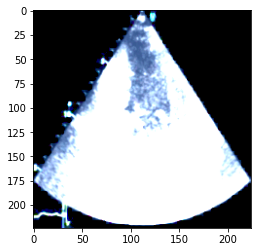

In [4]:
def imshow(images, labels, predicted, target_names):
  img = torchvision.utils.make_grid(images)
  plt.imshow(img.permute(1, 2, 0).cpu().numpy())
  [print(target_names[c], end=' ') for c in list(labels.cpu().numpy())]
  print()
  [print(target_names[c], end=' ') for c in list(predicted.cpu().numpy())]
  print()
  # print(target_names[list(labels.cpu().numpy())])
  # print(target_names[list(predicted.cpu().numpy())])

  # def imshow(img):
  #   img = img / 2 + 0.5     # unnormalize
  #   npimg = img.numpy()
  #   plt.imshow(np.transpose(npimg, (1, 2, 0)))
  #   plt.show()
def test():
  classes = get_classes()
  datasets = prepare_data()

  img, label = datasets.train[0]
  print(classes[label], img.size)
  print('Number of images in train', len(datasets.train), 'Number of images in test', len(datasets.test))
  plt.imshow(img.permute(1, 2, 0))

test()

In [5]:
# Hàm train với mỗi batch trong bộ dữ liệu
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  # Cho ảnh (đã được chia thành batch trong loader) lần lượt đi qua model, với mỗi ảnh và nhãn trong bộ dữ liệu là đầu vào của mạng.
  model.train()             
  running_loss = 0.0
  reporting_steps = 30
  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    # print('Type:', type(outputs), '\nOutput shape:', outputs.size())      # Type: <class 'torch.Tensor'> Output shape: torch.Size([32, 3])
    loss = loss_func(outputs, labels)

    # Cập nhật tham số trước khi sang step khác
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # Báo cáo sau reporting_step bước
    if i % reporting_steps == reporting_steps-1:
      print(f'Epoch {epoch} step {i} ave_loss {running_loss/reporting_steps:.4f}')
      running_loss = 0.0

# Hàm test 
def test_epoch(epoch, model, loader, device):
  ytrue =[]
  ypred = []
  # Đặt model ở chế độ đánh giá (evaluate)
  with torch.no_grad():
    model.eval()
    
    # Tính toán đầu ra cho từng ảnh, với nhãn dự đoán dựa trên số to nhất trong outputs
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      
      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())
      
  return ytrue, ypred   # Trả về nhãn thực, nhãn dự đoán của ảnh


In [6]:
def main(model_name=None):
  PATH = './' + model_name + '.pth'
  classes = get_classes()
  datasets = prepare_data()

  # img, label = datasets.train[0]
  # print(classes[label], img.size)
  # print('Number of images in train', len(datasets.train), 'Number of images in test', len(datasets.test))
  # plt.imshow(img)
  loaders = prepare_loader(datasets)
  # images, labels = iter(loaders.train).next()
  # print(images.shape, labels.shape)

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  if model_name == 'vgg19':
    model = VGG19()
  elif model_name == 'resnet50':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True)
  elif model_name == 'densenet121':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    model.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  else:
    pass
  # summary(model.cuda(), (3, 224, 224))
  # images, labels = iter(loaders.train).next()
  # # print(model)
  # outputs = model(images)
  # print(outputs.shape)
  # print(outputs[0])
  # _, predicted = torch.max(outputs, dim=1)
  # print(predicted)
  # imshow(images, labels, predicted, classes)
  print('Model name: ', model_name)
  model.to(device=device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  for epoch in range(20):
    train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ytrue, ypred = test_epoch(epoch, model, loaders.test, device)
    print(classification_report(ytrue, ypred, target_names=classes))


In [7]:
allmodels = ['vgg19', 'resnet50', 'densenet121']
for model in allmodels:
  main(model_name=model)


Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}
Type: <class 'torch.Tensor'> | size:  torch.Size([3, 224, 224])
Number of batchs in train: 210 
Number of batchs in test: 51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Model name:  vgg19
Epoch 0 step 29 ave_loss 29.7113
Epoch 0 step 59 ave_loss 16.7957
Epoch 0 step 89 ave_loss 5.8247
Epoch 0 step 119 ave_loss 1.4981
Epoch 0 step 149 ave_loss 1.0452
Epoch 0 step 179 ave_loss 1.0547
Epoch 0 step 209 ave_loss 1.0374
              precision    recall  f1-score   support

          2C       0.34      0.64      0.45       409
          3C       0.28      0.41      0.33       367
          4C       0.45      0.17      0.25       831

    accuracy                           0.34      1607
   macro avg       0.36      0.40      0.34      1607
weighted avg       0.38      0.34      0.32      1607

Epoch 1 step 29 ave_loss 1.0723
Epoch 1 step 59 ave_loss 1.0378
Epoch 1 step 89 ave_loss 1.0431
Epoch 1 step 119 ave_loss 1.0240
Epoch 1 step 149 ave_loss 1.0080
Epoch 1 step 179 ave_loss 1.0147
Epoch 1 step 209 ave_loss 1.0226
              precision    recall  f1-score   support

          2C       0.32      0.59      0.42       409
          3C       0.30      0.41

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


Model name:  resnet50
Epoch 0 step 29 ave_loss 4.9423
Epoch 0 step 59 ave_loss 1.5776
Epoch 0 step 89 ave_loss 1.1779
Epoch 0 step 119 ave_loss 1.2010
Epoch 0 step 149 ave_loss 1.1717
Epoch 0 step 179 ave_loss 1.1911
Epoch 0 step 209 ave_loss 1.1414
              precision    recall  f1-score   support

          2C       0.25      1.00      0.41       409
          3C       0.00      0.00      0.00       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.25      1607
   macro avg       0.08      0.33      0.14      1607
weighted avg       0.06      0.25      0.10      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 step 29 ave_loss 1.0793
Epoch 1 step 59 ave_loss 1.0917
Epoch 1 step 89 ave_loss 1.0579
Epoch 1 step 119 ave_loss 1.0458
Epoch 1 step 149 ave_loss 1.0851
Epoch 1 step 179 ave_loss 1.0239
Epoch 1 step 209 ave_loss 0.8476
              precision    recall  f1-score   support

          2C       0.44      0.51      0.47       409
          3C       0.00      0.00      0.00       367
          4C       0.57      0.77      0.66       831

    accuracy                           0.53      1607
   macro avg       0.34      0.43      0.38      1607
weighted avg       0.41      0.53      0.46      1607

Epoch 2 step 29 ave_loss 0.8965
Epoch 2 step 59 ave_loss 0.7464
Epoch 2 step 89 ave_loss 0.7984
Epoch 2 step 119 ave_loss 0.6711
Epoch 2 step 149 ave_loss 0.6666
Epoch 2 step 179 ave_loss 0.5831
Epoch 2 step 209 ave_loss 0.4540
              precision    recall  f1-score   support

          2C       0.36      0.69      0.47       409
          3C       0.63      0.27      0.38       367


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model name:  densenet121
Epoch 0 step 29 ave_loss 1.1628
Epoch 0 step 59 ave_loss 1.0660
Epoch 0 step 89 ave_loss 1.0066
Epoch 0 step 119 ave_loss 0.9620
Epoch 0 step 149 ave_loss 0.7812
Epoch 0 step 179 ave_loss 0.6723
Epoch 0 step 209 ave_loss 0.4987
              precision    recall  f1-score   support

          2C       0.99      0.22      0.37       409
          3C       0.66      0.71      0.68       367
          4C       0.62      0.84      0.71       831

    accuracy                           0.65      1607
   macro avg       0.76      0.59      0.59      1607
weighted avg       0.72      0.65      0.62      1607

Epoch 1 step 29 ave_loss 0.4753
Epoch 1 step 59 ave_loss 0.3532
Epoch 1 step 89 ave_loss 0.2937
Epoch 1 step 119 ave_loss 0.2524
Epoch 1 step 149 ave_loss 0.1984
Epoch 1 step 179 ave_loss 0.1978
Epoch 1 step 209 ave_loss 0.1782
              precision    recall  f1-score   support

          2C       0.72      0.80      0.76       409
          3C       0.45      

In [8]:
#VGG19 ảnh 224 raw: [44, 59, 69, 71, 71, 77, 73, 75, 75, 74, 76, 76, 78, 78, 79, 77, 82, 82, 73, 80]
#VGG19 ảnh 224 có data augmentation: [51, 43, 46, 47, 45, 47, 58, 56, 52, 58, 64, 63, 69, 78, 76, 81, 78, 77, 82, 75]
#VGG19 ảnh 224 có preprocess: [34, 37, 35, 38, 52, 63, 68, 65, 64, 62, 54, 66, 66, 64, 68, 68, 69, 68, 74, 76]

#RESNET50 ảnh 224 raw: [65, 76, 78, 87, 83, 86, 73, 80, 88, 84, 77, 90, 81, 87, 89, 88, 86, 89, 89, 88]
#RESNET50 ảnh 224 có data augmentation: [29, 62, 33, 72, 66, 73, 77, 80, 77, 75, 61, 82, 66, 77, 77, 76, 78, 75, 84, 74]
#RESNET50 ảnh 224 có preprocess: [25, 53, 53, 81, 85, 81, 85, 84, 86, 82, 86, 86, 90, 87, 86, 88, 86, 91, 87, 81]

#DENSENET121 ảnh 224 raw: [60, 83, 87, 86, 83, 85, 83, 75, 78, 81, 77, 77, 84, 74, 83, 81, 76, 81, 82, 84]
#DENSENET121 ảnh 224 có data augmentation: [60, 76, 64, 72, 29, 77, 65, 81, 62, 84, 65, 75, 57, 67, 74, 78, 72, 66, 74, 85]
#DENSENET121 ảnh 224 có preprocess: [65, 68, 66, 72, 88, 87, 83, 79, 84, 84, 89, 87, 77, 85, 71, 82, 82, 83, 85, 90]